In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/kaggle/input/spam-email/spam.csv')

In [3]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
data['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [5]:
data.isna().sum()

Category    0
Message     0
dtype: int64

In [20]:
def get_seq(texts, tokenizer, train = True, max_seq_length = None):
    seq = tokenizer.texts_to_sequences(texts)
    if train == True:
        max_seq_length = np.max(list(map(len, seq)))
    seq = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen = max_seq_length, padding = 'post')
    return seq

In [24]:
def preprocessing(df):
    df = df.copy()
    df['Category'] = df['Category'].replace({"ham" : 0, "spam" : 1})
    X = df['Message']
    Y = df['Category']
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, shuffle = True, random_state = 1)
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(x_train)
    print('Vocab Length : ' , len(tokenizer.word_index )+1)
    x_train = get_seq(texts = x_train, tokenizer = tokenizer, train = True)
    x_test = get_seq(texts = x_test, tokenizer = tokenizer, train = False, max_seq_length = x_train.shape[1])
    print('Sequence Length', x_train.shape[1])
    return x_train, x_test, y_train, y_test

In [25]:
x_train, x_test, y_train, y_test = preprocessing(data)
x_train

Vocab Length :  7383
Sequence Length 189


array([[  53,   21,   13, ...,    0,    0,    0],
       [ 918,    5, 1123, ...,    0,    0,    0],
       [1124,   58,   42, ...,    0,    0,    0],
       ...,
       [7377,    6, 7378, ...,    0,    0,    0],
       [  68,  167,  222, ...,    0,    0,    0],
       [ 104,  104,  206, ...,    0,    0,    0]], dtype=int32)

# Training

In [31]:
inputs = tf.keras.Input(shape = (189, ))
x = tf.keras.layers.Embedding(
    input_dim = 7383,
    output_dim = 250
)(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = [
        "accuracy",
        tf.keras.metrics.AUC(name = 'auc')
    ]
)
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 189)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 189, 250)          1845750   
_________________________________________________________________
flatten_3 (Flatten)          (None, 47250)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               6048128   
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 7,910,519
Trainable params: 7,910,519
Non-trainable params: 0
_________________________________________________

In [33]:
history = model.fit(
    x_train,
    y_train,
    validation_split = 0.2,
    batch_size = 32,
    epochs = 100,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 3,
        restore_best_weights = True)
    ]
)

2022-12-12 11:15:15.110224: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
98/98 [==============================] - 7s 59ms/step - loss: 0.1670 - accuracy: 0.9381 - auc: 0.9427 - val_loss: 0.0710 - val_accuracy: 0.9808 - val_auc: 0.9839
Epoch 2/100
98/98 [==============================] - 5s 47ms/step - loss: 0.0194 - accuracy: 0.9949 - auc: 0.9988 - val_loss: 0.1028 - val_accuracy: 0.9756 - val_auc: 0.9709
Epoch 3/100
98/98 [==============================] - 5s 47ms/step - loss: 0.0041 - accuracy: 0.9990 - auc: 1.0000 - val_loss: 0.0818 - val_accuracy: 0.9808 - val_auc: 0.9753
Epoch 4/100
98/98 [==============================] - 5s 51ms/step - loss: 0.0020 - accuracy: 0.9997 - auc: 1.0000 - val_loss: 0.0897 - val_accuracy: 0.9795 - val_auc: 0.9714


# Results


In [34]:
results = model.evaluate(x_test, y_test, verbose = 0)
print(f'Accuracy : {round(results[1]*100, 4)}%')
print(f'AUC : {round(results[2],3)}')

Accuracy : 97.8469%
AUC : 0.988


# Confusion Matrix and Classification Report


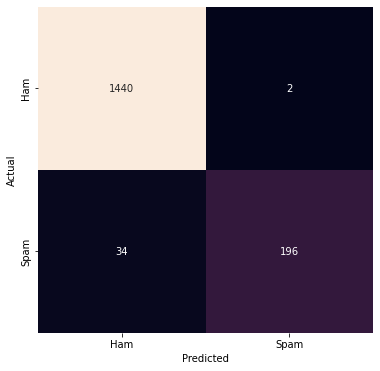

Classification Report ------------------->
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99      1442
        Spam       0.99      0.85      0.92       230

    accuracy                           0.98      1672
   macro avg       0.98      0.93      0.95      1672
weighted avg       0.98      0.98      0.98      1672



In [38]:
y_pred = np.squeeze(model.predict(x_test) >= 0.5).astype(np.int)
cm = confusion_matrix(y_test, y_pred,labels = [0,1] )
clr = classification_report(y_test, y_pred, labels = [0,1], target_names = ['Ham', "Spam"])
plt.figure(figsize = (6,6))
sns.heatmap(cm, annot = True, fmt = 'g', cbar = False)
plt.xticks(ticks = [0.5, 1.5], labels = ['Ham', "Spam"])
plt.yticks(ticks = [0.5, 1.5], labels = ['Ham', "Spam"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(f'Classification Report ------------------->\n{clr}')

> Almost perfect recall for ham emails

> Little less recall for spam as data was not equally distrubuted

> Over all good model
